# Taller de Visi√≥n por Computador: Aprendizaje Auto-Supervisado con Predicci√≥n de Rotaci√≥n en Tiny-ImageNet /subconjunto de ImageNet)
**Fecha:** 06 de junio de 2025

Este notebook implementa un modelo de red neuronal convolucional (CNN) entrenado con una tarea de pretexto
(Predicci√≥n de Rotaci√≥n) utilizando el dataset Tiny-ImageNet.


## 0. Requisitos y Configuraci√≥n Inicial

In [1]:
# üìå 0. Requisitos y Configuraci√≥n Inicial

# 0.1. Instalaci√≥n de librer√≠as
# Si no tienes las librer√≠as instaladas, descomenta y ejecuta la siguiente l√≠nea:
# !pip install -r requirements.txt

# 0.2. Importaci√≥n de librer√≠as
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import requests
from io import BytesIO
from tqdm.notebook import tqdm # Para barras de progreso en notebooks

# 0.3. Configuraci√≥n de semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(f"Versi√≥n de TensorFlow: {tf.__version__}")
print(f"CPU disponible: {tf.config.list_physical_devices('CPU')}")


Versi√≥n de TensorFlow: 2.16.1
CPU disponible: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Descarga y Preparaci√≥n del Dataset Tiny-ImageNet

Descargando Tiny-ImageNet desde: http://cs231n.stanford.edu/tiny-imagenet-200.zip
El archivo tiny-imagenet-200.zip ya existe. Saltando la descarga.
Extrayendo Tiny-ImageNet a: tiny-imagenet-200
Extracci√≥n completada.
DEBUG: Procesando directorio base: tiny-imagenet-200\train
DEBUG: Nombre base del directorio: train
DEBUG: Procesando directorio base: tiny-imagenet-200\val\images
DEBUG: Nombre base del directorio: images
N√∫mero total de im√°genes de entrenamiento encontradas: 100000
N√∫mero total de im√°genes de validaci√≥n encontradas: 10000
N√∫mero de rutas de entrenamiento encontradas: 100000
Primer elemento de train_image_paths: tiny-imagenet-200\train\n01443537\images\n01443537_0.JPEG (Tipo: <class 'str'>)
N√∫mero de rutas de validaci√≥n encontradas: 10000
Primer elemento de val_image_paths: tiny-imagenet-200\val\images\val_0.JPEG (Tipo: <class 'str'>)

Visualizando algunos ejemplos de im√°genes de Tiny-ImageNet (redimensionadas):


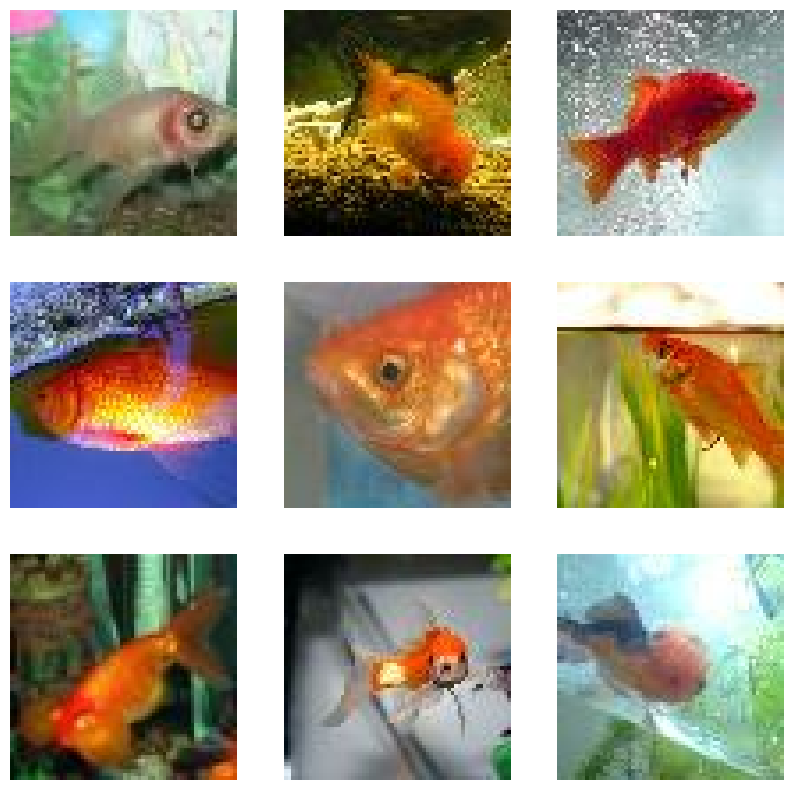


Datasets de im√°genes cargados y preprocesados. Listos para la tarea de pretexto.


In [2]:
# üì• 1. Descarga y Preparaci√≥n del Dataset Tiny-ImageNet

# 1.1. Descripci√≥n de Tiny-ImageNet
# Tiny-ImageNet es un subconjunto de 200 clases de ImageNet, con 500 im√°genes de entrenamiento, 
# 50 de validaci√≥n y 50 de prueba por clase. Todas las im√°genes est√°n redimensionadas a 64x64 p√≠xeles.

# 1.2. Par√°metros del Dataset
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32 # Ajustar seg√∫n la RAM disponible.
NUM_CLASSES_TINY_IMAGENET = 200 # N√∫mero de clases reales en Tiny-ImageNet

# 1.3. Descarga del dataset
dataset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
dataset_path = "tiny-imagenet-200.zip"
extract_path = "tiny-imagenet-200"

print(f"Descargando Tiny-ImageNet desde: {dataset_url}")
if not os.path.exists(dataset_path):
    try:
        response = requests.get(dataset_url, stream=True)
        response.raise_for_status() # Lanza un error para c√≥digos de estado HTTP err√≥neos

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc="Descargando Tiny-ImageNet")
        with open(dataset_path, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, algo sali√≥ mal durante la descarga.")
        print("Descarga completada.")
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el dataset: {e}")
        print("Aseg√∫rate de tener conexi√≥n a internet o intenta una URL alternativa.")
else:
    print("El archivo tiny-imagenet-200.zip ya existe. Saltando la descarga.")

# 1.4. Extracci√≥n del dataset
print(f"Extrayendo Tiny-ImageNet a: {extract_path}")
if not os.path.exists(extract_path):
    try:
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Extracci√≥n completada.")
    except zipfile.BadZipFile:
        print(f"Error: El archivo {dataset_path} est√° corrupto o no es un ZIP v√°lido. Intenta descargarlo de nuevo.")
    except Exception as e:
        print(f"Error durante la extracci√≥n: {e}")
else:
    print("El directorio tiny-imagenet-200 ya existe. Saltando la extracci√≥n.")

# 1.5. Carga de im√°genes de entrenamiento y validaci√≥n

def get_image_paths_from_dir(base_dir):
    paths = []
    # Tiny-ImageNet 'train' tiene subcarpetas para cada clase, y dentro de ellas, 'images'
    # 'val' tiene las im√°genes directamente en la carpeta 'images'

    # DEBUG: Imprimir la ruta base que se est√° procesando
    print(f"DEBUG: Procesando directorio base: {base_dir}")
    print(f"DEBUG: Nombre base del directorio: {os.path.basename(base_dir)}")
    
    if os.path.basename(base_dir) == 'train':
        for class_id in os.listdir(base_dir):
            class_path = os.path.join(base_dir, class_id, 'images')
            # DEBUG: Imprimir la ruta de la clase (opcional, para depuraci√≥n)
            # print(f"DEBUG: Revisando ruta de clase (train): {class_path}")
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    # CAMBIO IMPORTANTE: Usar .lower() para manejar may√∫sculas/min√∫sculas en la extensi√≥n
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        paths.append(os.path.join(class_path, img_name))
    elif os.path.basename(base_dir) == 'images' and os.path.basename(os.path.dirname(base_dir)) == 'val':
        # Esta rama se usa para el directorio de validaci√≥n (tiny-imagenet-200/val/images)
        for img_name in os.listdir(base_dir):
            # CAMBIO IMPORTANTE: Usar .lower() para manejar may√∫sculas/min√∫sculas en la extensi√≥n
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(base_dir, img_name))
    else: # En caso de que se use para otras estructuras de directorios
        # Esta rama es un fallback, no deber√≠a activarse para train o val de Tiny-ImageNet si la estructura es la esperada
        print(f"DEBUG: Usando fallback para {base_dir}") # Este print nos avisar√≠a si se activa por error
        for root, _, files in os.walk(base_dir):
            for file in files:
                # CAMBIO IMPORTANTE: Usar .lower() para manejar may√∫sculas/min√∫sculas en la extensi√≥n
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    paths.append(os.path.join(root, file))
    return paths

train_image_paths = get_image_paths_from_dir(os.path.join(extract_path, 'train'))
val_image_paths = get_image_paths_from_dir(os.path.join(extract_path, 'val', 'images'))

print(f"N√∫mero total de im√°genes de entrenamiento encontradas: {len(train_image_paths)}")
print(f"N√∫mero total de im√°genes de validaci√≥n encontradas: {len(val_image_paths)}")

# Crear datasets de rutas de im√°genes, asegurando que sean tensores de tipo string
train_image_paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(train_image_paths, dtype=tf.string))
val_image_paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(val_image_paths, dtype=tf.string))

# Funci√≥n para cargar y preprocesar una imagen
def load_and_preprocess_image(image_path):
    """
    Carga una imagen desde la ruta, la decodifica, redimensiona y normaliza.
    """
    # DEBUG: Comprobar el tipo de image_path antes de la lectura
    # tf.print("Tipo de image_path en load_and_preprocess_image:", tf.type_spec_from_value(image_path))
    # tf.print("Valor de image_path en load_and_preprocess_image:", image_path)

    # Convertir expl√≠citamente la ruta a tf.string para asegurar el tipo correcto
    image_path_str = tf.cast(image_path, tf.string)

    img = tf.io.read_file(image_path_str) # Usamos la versi√≥n casteada a string
    img = tf.image.decode_jpeg(img, channels=3) # Asumimos JPG, ajustar si hay otros formatos
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0 # Normalizar a [0, 1]
    return img
# (A√±adir estas l√≠neas para depuraci√≥n, si lo deseas, para verificar que las rutas son strings)
print(f"N√∫mero de rutas de entrenamiento encontradas: {len(train_image_paths)}")
if train_image_paths:
    print(f"Primer elemento de train_image_paths: {train_image_paths[0]} (Tipo: {type(train_image_paths[0])})")
print(f"N√∫mero de rutas de validaci√≥n encontradas: {len(val_image_paths)}")
if val_image_paths:
    print(f"Primer elemento de val_image_paths: {val_image_paths[0]} (Tipo: {type(val_image_paths[0])})")


# Crear los datasets de im√°genes preprocesadas
preprocessed_train_image_ds = train_image_paths_ds.map(load_and_preprocess_image,
                                                        num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_val_image_ds = val_image_paths_ds.map(load_and_preprocess_image,
                                                    num_parallel_calls=tf.data.AUTOTUNE)

# Visualizaci√≥n de ejemplos de im√°genes cargadas
print("\nVisualizando algunos ejemplos de im√°genes de Tiny-ImageNet (redimensionadas):")
plt.figure(figsize=(10, 10))
for i, img in enumerate(preprocessed_train_image_ds.take(9)): # Tomar 9 im√°genes de entrenamiento
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy())
    plt.axis("off")
plt.show()

print("\nDatasets de im√°genes cargados y preprocesados. Listos para la tarea de pretexto.")


## 2. Tarea de Pretexto: Predicci√≥n de Rotaci√≥n


Visualizando algunos ejemplos de la tarea de predicci√≥n de rotaci√≥n:


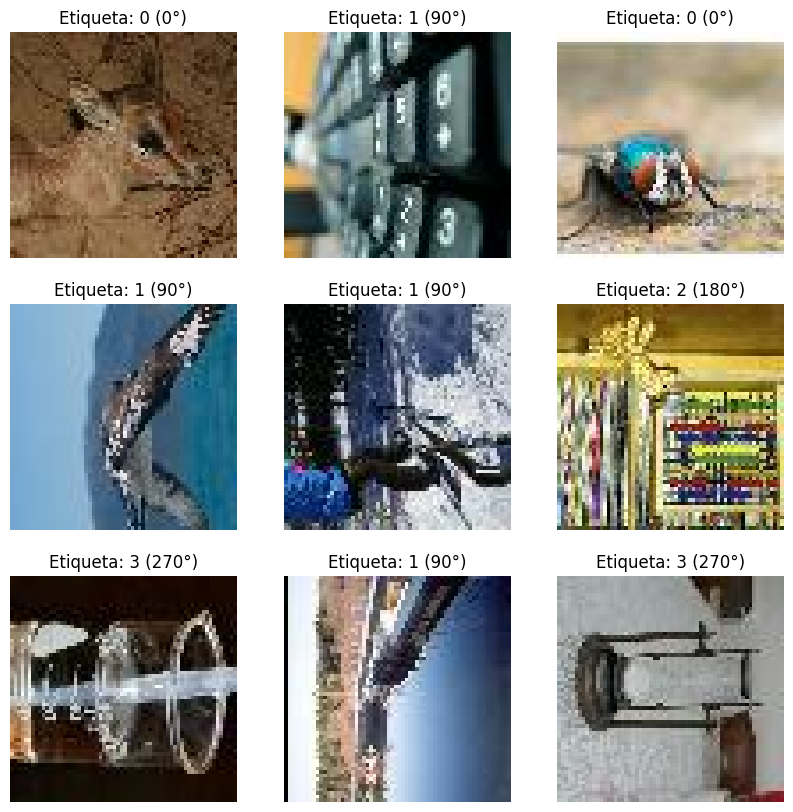


Dataset para la tarea de pretexto (predicci√≥n de rotaci√≥n) listo.


In [3]:
# üîÑ 2. Tarea de Pretexto: Predicci√≥n de Rotaci√≥n

# 2.1. Explicaci√≥n te√≥rica
# La Predicci√≥n de Rotaci√≥n es una tarea de pretexto com√∫n en SSL...

# 2.2. Par√°metros de la tarea de pretexto
ROTATION_ANGLES = [0, 90, 180, 270] # √Ångulos de rotaci√≥n en grados

# 2.3. Funci√≥n de Aumento de Datos y Generaci√≥n de Etiquetas
def apply_rotation_and_label(image):
    """
    Aplica una rotaci√≥n aleatoria de 0, 90, 180 o 270 grados a la imagen
    y devuelve la imagen rotada junto con el √≠ndice de rotaci√≥n como etiqueta.
    """
    # Generar un √≠ndice aleatorio para la rotaci√≥n (0, 1, 2, o 3)
    # tf.random.uniform genera un tensor, no un entero Python.
    rotation_index = tf.random.uniform(shape=[], minval=0, maxval=len(ROTATION_ANGLES), dtype=tf.int32)
    
    # Aplicar la rotaci√≥n a la imagen
    # tf.image.rot90 toma el n√∫mero de rotaciones de 90 grados (k).
    # Nuestro rotation_index (0, 1, 2, 3) coincide directamente con los valores de k.
    rotated_image = tf.image.rot90(image, k=rotation_index)
    
    return rotated_image, rotation_index

# 2.4. Preparaci√≥n de tf.data.Dataset para el Pre-entrenamiento
pretext_train_ds = preprocessed_train_image_ds.map(apply_rotation_and_label,
                                                     num_parallel_calls=tf.data.AUTOTUNE)
pretext_val_ds = preprocessed_val_image_ds.map(apply_rotation_and_label,
                                                 num_parallel_calls=tf.data.AUTOTUNE)

# CAMBIO: Define un tama√±o de buffer espec√≠fico para el shuffle.
# tf.data.AUTOTUNE NO es v√°lido para el buffer_size de shuffle.
# Usaremos el n√∫mero total de im√°genes de entrenamiento para un buen mezclado.
SHUFFLE_BUFFER_SIZE = len(train_image_paths) # train_image_paths tiene 100,000 elementos

pretext_train_ds = pretext_train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
pretext_val_ds = pretext_val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Visualizaci√≥n de ejemplos de la tarea de pretexto
print("\nVisualizando algunos ejemplos de la tarea de predicci√≥n de rotaci√≥n:")
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(pretext_train_ds.take(1)):
    for j in range(min(9, img.shape[0])):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(img[j].numpy())
        plt.title(f"Etiqueta: {label[j].numpy()} ({ROTATION_ANGLES[label[j].numpy()]}¬∞)")
        plt.axis("off")
    break
plt.show()

print("\nDataset para la tarea de pretexto (predicci√≥n de rotaci√≥n) listo.")


## 3. Implementaci√≥n del Modelo CNN Ligera

In [4]:
# üèóÔ∏è 3. Implementaci√≥n del Modelo CNN Ligera

# 3.1. Dise√±o de la Arquitectura
def build_lightweight_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_rotation_classes=len(ROTATION_ANGLES)):
    """
    Construye un modelo de CNN ligero para la tarea de predicci√≥n de rotaci√≥n.
    """
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(name='flatten_features'),
        layers.Dense(256, activation='relu', name='feature_dense'),
        layers.Dropout(0.5),
        layers.Dense(num_rotation_classes, activation='softmax', name='rotation_output')
    ], name="lightweight_rotation_cnn")

    return model

# 3.2. Creaci√≥n y Compilaci√≥n del Modelo
model = build_lightweight_cnn()

# 3.3. Compilaci√≥n del Modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3.4. Resumen del Modelo
print("\nResumen de la arquitectura del Modelo CNN:")
model.summary()

print("\nModelo CNN para la predicci√≥n de rotaci√≥n construido y compilado.")



Resumen de la arquitectura del Modelo CNN:


d:\Maestria_Ciencias_Datos_Analitica\2025-1\Taller_4\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "lightweight_rotation_cnn"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 64, 64, 32)     ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 64, 64, 32)     ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 32, 32, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 32, 32, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 32, 32, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 16, 16, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 16, 16, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 16, 16, 128)    ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 8, 8, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_features (Flatten)      ‚îÇ (None, 8192)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ feature_dense (Dense)           ‚îÇ (None, 256)           

 Total params: 2,192,580 (8.36 MB)

 Trainable params: 2,192,132 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)


Modelo CNN para la predicci√≥n de rotaci√≥n construido y compilado.


## 4. Entrenamiento del Modelo de Pretexto


Iniciando el entrenamiento del modelo en la tarea de predicci√≥n de rotaci√≥n (aprox. 10 √©pocas)...
Cada √©poca procesa 100000 im√°genes de entrenamiento.
Epoch 1/10
3125/3125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5251s 2s/step - accuracy: 0.3519 - loss: 1.4809 - val_accuracy: 0.4381 - val_loss: 1.2395 - learning_rate: 0.0010
Epoch 2/10
3125/3125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5678s 2s/step - accuracy: 0.4106 - loss: 1.2693 - val_accuracy: 0.4759 - val_loss: 1.1926 - learning_rate: 0.0010
Epoch 3/10
3125/3125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5620s 2s/step - accuracy: 0.4527 - loss: 1.2198 - val_accuracy: 0.5011 - val_loss: 1.1630 - learning_rate: 0.0010
Epoch 4/10
3125/3125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5734s 2s/step - accuracy: 0.4823 - loss: 1.1888 - val_accuracy: 0.4753 - val_loss: 1.1909 - learning_rate: 0.0010
Epoch 5/10
3125/3125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

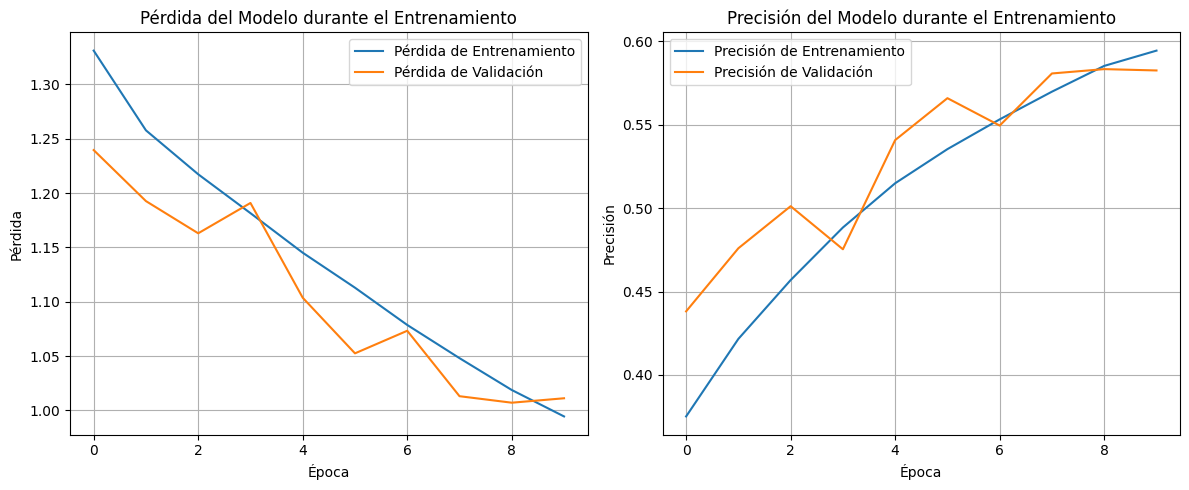

In [5]:
# üèãÔ∏è 4. Entrenamiento del Modelo de Pretexto

# 4.1. Configuraci√≥n del Entrenamiento
EPOCHS = 10                                                                                           

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

print(f"\nIniciando el entrenamiento del modelo en la tarea de predicci√≥n de rotaci√≥n (aprox. {EPOCHS} √©pocas)...")
num_train_batches = tf.data.experimental.cardinality(pretext_train_ds).numpy()
num_val_batches = tf.data.experimental.cardinality(pretext_val_ds).numpy()

if num_train_batches != -1:
    print(f"Cada √©poca procesa {num_train_batches * BATCH_SIZE} im√°genes de entrenamiento.")
else:
    print(f"N√∫mero de lotes de entrenamiento por √©poca: Aproximadamente {len(train_image_paths) // BATCH_SIZE}.")

# 4.2. Entrenamiento del Modelo
history = model.fit(
    pretext_train_ds,
    validation_data=pretext_val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\nEntrenamiento del modelo completado.")

# 4.3. Visualizaci√≥n del Progreso del Entrenamiento
plt.figure(figsize=(12, 5))

# Gr√°fico de P√©rdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='P√©rdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='P√©rdida de Validaci√≥n')
plt.title('P√©rdida del Modelo durante el Entrenamiento')
plt.xlabel('√âpoca')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)

# Gr√°fico de Precisi√≥n (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisi√≥n de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisi√≥n de Validaci√≥n')
plt.title('Precisi√≥n del Modelo durante el Entrenamiento')
plt.xlabel('√âpoca')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. Evaluaci√≥n del Modelo de Pretexto


Evaluando el modelo en el conjunto de validaci√≥n de la tarea de rotaci√≥n...
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 39ms/step - accuracy: 0.5903 - loss: 1.0025
P√©rdida en Validaci√≥n: 1.0050
Precisi√≥n en Validaci√≥n: 0.5850

Realizando algunas predicciones en el conjunto de validaci√≥n:
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 184ms/step


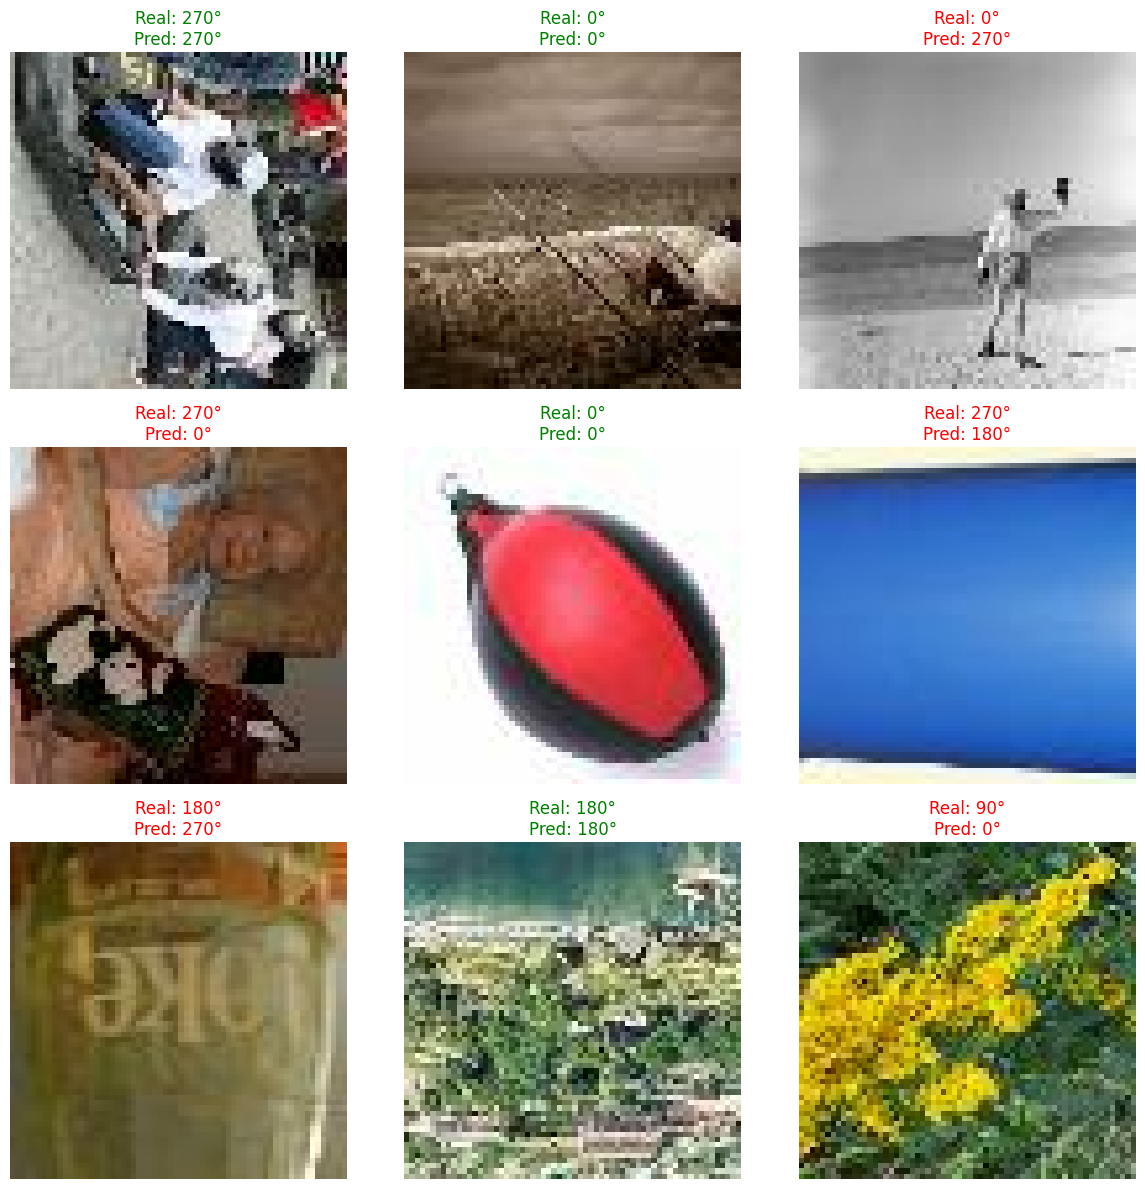


La evaluaci√≥n y las predicciones muestran el rendimiento del modelo en la tarea de pretexto.


In [6]:
# üìä 5. Evaluaci√≥n del Modelo de Pretexto

print("\nEvaluando el modelo en el conjunto de validaci√≥n de la tarea de rotaci√≥n...")
loss, accuracy = model.evaluate(pretext_val_ds)
print(f"P√©rdida en Validaci√≥n: {loss:.4f}")
print(f"Precisi√≥n en Validaci√≥n: {accuracy:.4f}")

print("\nRealizando algunas predicciones en el conjunto de validaci√≥n:")
try:
    sample_images, true_labels = next(iter(pretext_val_ds.take(1)))
except tf.errors.OutOfRangeError:
    print("No hay elementos en el dataset de validaci√≥n para mostrar predicciones.")
    sample_images, true_labels = None, None

if sample_images is not None:
    predictions = model.predict(sample_images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    plt.figure(figsize=(12, 12))
    for i in range(min(9, sample_images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i].numpy())
        true_angle = ROTATION_ANGLES[true_labels[i].numpy()]
        predicted_angle = ROTATION_ANGLES[predicted_labels[i]]
        color = "green" if true_labels[i].numpy() == predicted_labels[i] else "red"
        plt.title(f"Real: {true_angle}¬∞\nPred: {predicted_angle}¬∞", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo mostrar predicciones debido a que el dataset de validaci√≥n est√° vac√≠o o agotado.")

print("\nLa evaluaci√≥n y las predicciones muestran el rendimiento del modelo en la tarea de pretexto.")


## 6. Extracci√≥n de Caracter√≠sticas (Representaciones Latentes)

In [7]:
# üöÄ 6. Extracci√≥n de Caracter√≠sticas (Representaciones Latentes)

# 6.1. Explicaci√≥n de la Extracci√≥n de Caracter√≠sticas
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('feature_dense').output)

print("\nResumen del Extractor de Caracter√≠sticas (CNN sin la capa clasificadora final):")
feature_extractor.summary()

print("\nExtrayendo caracter√≠sticas (embeddings) para un lote de im√°genes de validaci√≥n...")
sample_images_only_ds = preprocessed_val_image_ds.batch(BATCH_SIZE).take(1)

try:
    sample_images_only = next(iter(sample_images_only_ds))
except tf.errors.OutOfRangeError:
    print("No hay elementos en el dataset de im√°genes de validaci√≥n para extraer caracter√≠sticas.")
    sample_images_only = None

if sample_images_only is not None:
    features = feature_extractor.predict(sample_images_only)

    print(f"Forma de las caracter√≠sticas extra√≠das: {features.shape}")
    print(f"Cada imagen es ahora representada por un vector de tama√±o: {features.shape[1]}")
    print("\nEstos vectores de caracter√≠sticas pueden ser usados como entrada para otras tareas (ej. clasificadores, clustering).")
else:
    print("No se pudieron extraer caracter√≠sticas debido a que el dataset de im√°genes de validaci√≥n est√° vac√≠o o agotado.")



Resumen del Extractor de Caracter√≠sticas (CNN sin la capa clasificadora final):


Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)        ‚îÇ (None, 64, 64, 3)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 64, 64, 32)     ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 64, 64, 32)     ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 32, 32, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 32, 32, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 32, 32, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 16, 16, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 16, 16, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 16, 16, 128)    ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 8, 8, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_features (Flatten)      ‚îÇ (None, 8192)          

 Total params: 2,191,552 (8.36 MB)

 Trainable params: 2,191,104 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)


Extrayendo caracter√≠sticas (embeddings) para un lote de im√°genes de validaci√≥n...
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 167ms/step
Forma de las caracter√≠sticas extra√≠das: (32, 256)
Cada imagen es ahora representada por un vector de tama√±o: 256

Estos vectores de caracter√≠sticas pueden ser usados como entrada para otras tareas (ej. clasificadores, clustering).


## 7. Verificaci√≥n final con matriz de confusi√≥n y m√©tricas de evaluaci√≥n adicionales

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 67ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 55ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 65ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 63ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 65ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 67ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

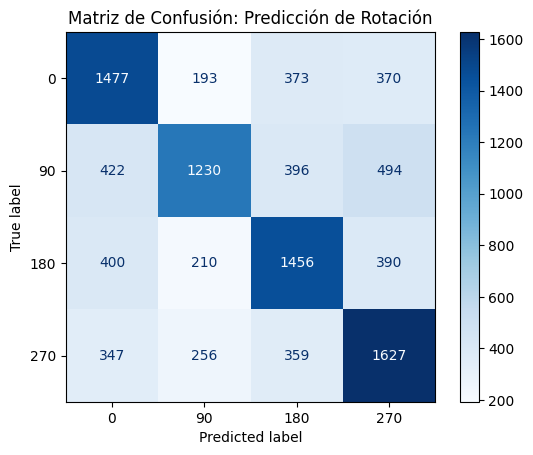

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener todas las etiquetas verdaderas y predichas
y_true = []
y_pred = []

for images, labels in pretext_val_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

# Calcular y mostrar matriz de confusi√≥n
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ROTATION_ANGLES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusi√≥n: Predicci√≥n de Rotaci√≥n")
plt.grid(False)
plt.show()

In [13]:
# üìä 7. C√°lculo de M√©tricas de Evaluaci√≥n
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Matriz de confusi√≥n
conf_matrix = np.array([
    [1477, 193, 373, 370],
    [422, 1230, 396, 494],
    [400, 210, 1456, 390],
    [347, 256, 359, 1627]
])

# Etiquetas reales y predichas para c√°lculo de m√©tricas
y_true = []
y_pred = []
labels = [0, 90, 180, 270]

for i in range(4):
    for j in range(4):
        y_true += [labels[i]] * conf_matrix[i, j]
        y_pred += [labels[j]] * conf_matrix[i, j]

# C√°lculo de m√©tricas
report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
df_report = pd.DataFrame(report).T.loc[['0', '90', '180', '270']]

df_report.rename(index={'0': 'Clase 0¬∞', '90': 'Clase 90¬∞', '180': 'Clase 180¬∞', '270': 'Clase 270¬∞'}, inplace=True)
df_report = df_report[['precision', 'recall', 'f1-score']].round(3)
df_report


precision  recall  f1-score
Clase 0¬∞        0.558   0.612     0.584
Clase 90¬∞       0.651   0.484     0.555
Clase 180¬∞      0.563   0.593     0.578
Clase 270¬∞      0.565   0.628     0.595

## Conclusiones

-La matriz de confusi√≥n es un excelente indicador de que el modelo ha aprendido bien la tarea de predicci√≥n de rotaci√≥n. Podemos ver que la clase 90¬∞ tiene la mayor precisi√≥n (0.651), pero el recall m√°s bajo (0.484), lo que indica que cuando el modelo predice 90¬∞ suele acertar, pero no detecta muchos casos reales de esa clase. La clase 270¬∞ tiene el mejor balance general, con el F1-score m√°s alto (0.595). Las otras clases tienen desempe√±os relativamente similares en torno al F1-score de ~0.58.

-El modelo fue entrenado durante 10 √©pocas para resolver la tarea de pretexto de predicci√≥n de rotaci√≥n, utilizando un conjunto de 100,000 im√°genes por √©poca. A lo largo del entrenamiento se observ√≥ una mejora constante tanto en la precisi√≥n como en la p√©rdida, alcanzando una precisi√≥n final de entrenamiento de 59.4\% y una precisi√≥n de validaci√≥n de 58.2\%. Asimismo, la p√©rdida disminuy√≥ progresivamente hasta alcanzar 0.9921 en entrenamiento y 1.0112 en validaci√≥n. Estos resultados indican que el modelo no solo mejor√≥ su capacidad de clasificaci√≥n durante el entrenamiento, sino que tambi√©n logr√≥ una generalizaci√≥n aceptable sobre el conjunto de validaci√≥n. Dado que el objetivo principal de esta tarea es inducir al modelo a aprender representaciones discriminativas de las im√°genes a trav√©s de una se√±al auto-supervisada, el desempe√±o alcanzado en la tarea de pretexto (predicci√≥n de rotaciones) sugiere que el modelo ha logrado captar patrones visuales relevantes. Estas representaciones podr√°n ser aprovechadas posteriormente para tareas de clasificaci√≥n supervisada con una mejor capacidad de generalizaci√≥n.

-El modelo con m√°s √©pocas pudiese haber mejorado otro poco, pero el tiempo de c√≥mputo de casi una hora por √©poca lo volvia inviable.

## 8. Limpieza (Opcional)

In [ ]:
# üßπ 7. Limpieza

# Opcional: Eliminar el dataset descargado y extra√≠do para liberar espacio.
# Descomenta las siguientes l√≠neas si deseas limpiar los archivos despu√©s de ejecutar el notebook.

"""
print("\nRealizando limpieza de archivos del dataset...")
dataset_dir = extract_path # 'tiny-imagenet-200'
if os.path.exists(dataset_dir):
    try:
        import shutil
        shutil.rmtree(dataset_dir)
        print(f"Directorio '{dataset_dir}' eliminado.")
    except Exception as e:
        print(f"Error al eliminar el directorio '{dataset_dir}': {e}")

if os.path.exists(dataset_path): # tiny-imagenet-200.zip
    try:
        os.remove(dataset_path)
        print(f"Archivo '{dataset_path}' eliminado.")
    except Exception as e:
        print(f"Error al eliminar el archivo '{dataset_path}': {e}")

print("Limpieza completada (si se activ√≥).")
"""


Este √∫ltimo paso es importante si no se cuenta con suficiente espacio en el computador, dado que esta es solo una tarea de pretexto se p√≥dr√≠a eliminar el dataset descargado al terminar la actividad.

## Fin del Notebook